In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load and format data

Loading and formatting all the relevant data, also grabbing the top 200 peaks by LogFC per cell type (stored in count_data_topdiff)

In [2]:
fimo_counts = dict()
fimo_base_dir = "/oak/stanford/groups/akundaje/projects/dnalm_benchmark/cell_line_data/"
cell_line_list = ["K562", "GM12878", "HEPG2", "IMR90", "H1ESC"]
fimo_file_list = []
for cell_line in cell_line_list:
    fimo_counts[cell_line] = pd.read_csv(fimo_base_dir + cell_line + "/fimo_out/fimo.tsv", sep="\t")[["motif_id", "sequence_name", "start", "stop", "p-value"]]
    fimo_counts[cell_line] = fimo_counts[cell_line][fimo_counts[cell_line]["p-value"]<1e-5][["motif_id", "sequence_name", "start", "stop"]]

In [3]:
peak_file = "/oak/stanford/groups/akundaje/projects/dnalm_benchmark/cell_line_data/peaks_by_cell_label_unique_dataloader_format.tsv"
peak_table = pd.read_csv(peak_file, sep="\t")

In [4]:
peak_table.shape

(216746, 7)

In [5]:
for cell_line in cell_line_list:
    peaks_df = peak_table[peak_table["label"]==cell_line][["chr", "input_start", "input_end"]].reset_index()
    peaks_df["index"] = ["peak"+str(i) for i in peaks_df["index"]]
    peaks_df = peaks_df.rename(columns={"index" : "peaks"})
    peaks_df = peaks_df[["chr", "input_start", "input_end", "peaks"]]
    motifs_df = fimo_counts[cell_line][fimo_counts[cell_line]['sequence_name'].isin(peaks_df['chr'].unique())]
    motifs_df = motifs_df[['sequence_name', 'start', 'stop', 'motif_id']]
    motifs_df["start"] = motifs_df["start"].astype(int)
    motifs_df["stop"] = motifs_df["stop"].astype(int)
    peaks_df.to_csv(cell_line+'peaks.bed', sep='\t', header=False, index=False)
    motifs_df.to_csv(cell_line+'motifs.bed', sep='\t', header=False, index=False)

In [6]:
# command line run:
# for cell_line in "K562" "GM12878" "H1ESC" "HEPG2" "IMR90"; do bedtools intersect -a ${cell_line}peaks.bed -b ${cell_line}motifs.bed -wa -wb > ${cell_line}intersected.bed; done

In [7]:
intersected = dict()
value_counts = dict()
for cell_line in cell_line_list:
    df = pd.read_csv(cell_line+"intersected.bed", sep="\t", names=["peak_chr", "peak_start", "peak_end", "peak_name",
                                                    "motif_chr", "motif_start", "motif_end", "motif_name"])
    df = df[(df.peak_chr==df.motif_chr) & (df.peak_start < df.motif_start) & (df.peak_end > df.motif_end)]
    intersected[cell_line] = df[["motif_name", "peak_name"]]
    value_counts[cell_line] = intersected[cell_line].value_counts()

In [8]:
k562_table = pd.crosstab(intersected["K562"]['motif_name'], intersected["K562"]['peak_name'])
imr90_table = pd.crosstab(intersected["IMR90"]['motif_name'], intersected["IMR90"]['peak_name'])
hepg2_table = pd.crosstab(intersected["HEPG2"]['motif_name'], intersected["HEPG2"]['peak_name'])
h1esc_table = pd.crosstab(intersected["H1ESC"]['motif_name'], intersected["H1ESC"]['peak_name'])
gm12878_table = pd.crosstab(intersected["GM12878"]['motif_name'], intersected["GM12878"]['peak_name'])

In [9]:
k562_table

peak_name,peak0,peak1,peak10,peak1000,peak10002,peak10003,peak10004,peak10005,peak100090,peak100092,...,peak999,peak9992,peak99925,peak99926,peak99927,peak9993,peak99934,peak99943,peak9996,peak99964
motif_name,,,,,,,,,,,,,,,,,,,,,
AHR.H12CORE.0.P.B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AHRR.H12CORE.0.P.C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ALX1.H12CORE.0.SM.B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ALX3.H12CORE.0.SM.B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ALX3.H12CORE.1.S.B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSC29.H12CORE.1.M.C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZSC31.H12CORE.0.P.C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZSC31.H12CORE.1.SM.B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [10]:
peak_motif_counts = pd.concat([k562_table, imr90_table, hepg2_table, h1esc_table, gm12878_table], axis=1)

In [11]:
np.max(peak_motif_counts)
np.quantile(peak_motif_counts, 0.75), np.quantile(peak_motif_counts, 0.25), np.quantile(peak_motif_counts, 0.5)

(0.0, 0.0, 0.0)

In [12]:
np.unique(peak_motif_counts)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 105,
       106, 107, 109, 110, 112, 113, 114, 116, 117, 120, 125, 126, 129,
       133, 135, 138, 146, 155, 156, 167, 168, 176])

In [13]:
peak_motif_counts_filtered = peak_motif_counts.loc[~(peak_motif_counts < 5).all(axis=1)]

In [14]:
peak_motif_counts_filtered

peak_name,peak0,peak1,peak10,peak1000,peak10002,peak10003,peak10004,peak10005,peak100090,peak100092,...,peak99948,peak99953,peak99954,peak99958,peak99959,peak99962,peak99965,peak99966,peak99967,peak9999
motif_name,,,,,,,,,,,,,,,,,,,,,
AHR.H12CORE.0.P.B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AHRR.H12CORE.0.P.C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ANDR.H12CORE.0.P.B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ARNT.H12CORE.1.P.B,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
ARNT2.H12CORE.0.P.B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSC22.H12CORE.0.P.C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZSC31.H12CORE.0.P.C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ZSC31.H12CORE.1.SM.B,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [15]:
# Step 1: Load and normalize the counts matrix
scaler = StandardScaler()
  # Transpose for normalization

In [16]:
peak_motif_counts_filtered.shape

(537, 216745)

In [17]:
feature_variances = np.var(peak_motif_counts_filtered, axis=1)
feature_variances

motif_name
AHR.H12CORE.0.P.B       0.006892
AHRR.H12CORE.0.P.C      0.005338
ANDR.H12CORE.0.P.B      0.024809
ARNT.H12CORE.1.P.B      0.008754
ARNT2.H12CORE.0.P.B     0.007120
                          ...   
ZSC22.H12CORE.0.P.C     0.186125
ZSC31.H12CORE.0.P.C     0.037353
ZSC31.H12CORE.1.SM.B    0.028628
ZSCA1.H12CORE.0.SM.B    1.353357
ZSCA4.H12CORE.0.SM.B    0.022168
Length: 537, dtype: float64

In [18]:
# Step 2: Calculate feature variability

high_variability_threshold = np.percentile(feature_variances, 80)
high_variability_features = peak_motif_counts_filtered.index[feature_variances >= high_variability_threshold]
variable_features = peak_motif_counts_filtered[feature_variances >= high_variability_threshold]
variable_features = np.log10(1 + variable_features)
normalized_matrix = scaler.fit_transform(variable_features.T).T

In [19]:
variable_features.shape

(108, 216745)

In [20]:
for i in variable_features.index:
    print(i)

CPEB1.H12CORE.1.S.B
FLI1.H12CORE.1.P.B
FOXC2.H12CORE.0.SM.B
FOXL1.H12CORE.0.S.B
FOXR2.H12CORE.0.M.C
IRF8.H12CORE.0.P.B
KLF1.H12CORE.0.P.B
KLF10.H12CORE.0.P.C
KLF10.H12CORE.1.PSM.A
KLF11.H12CORE.0.P.B
KLF11.H12CORE.1.SM.B
KLF12.H12CORE.0.P.C
KLF13.H12CORE.1.P.C
KLF14.H12CORE.1.P.C
KLF15.H12CORE.0.S.B
KLF15.H12CORE.1.P.C
KLF16.H12CORE.1.P.B
KLF17.H12CORE.1.P.C
KLF3.H12CORE.0.PS.A
KLF6.H12CORE.0.P.B
KLF7.H12CORE.0.P.B
KLF8.H12CORE.0.P.C
KLF8.H12CORE.1.P.C
KLF9.H12CORE.0.P.B
KLF9.H12CORE.1.P.B
KMT2A.H12CORE.0.P.B
MAZ.H12CORE.0.P.B
MAZ.H12CORE.1.P.B
PATZ1.H12CORE.0.P.B
PATZ1.H12CORE.1.P.C
PRDM6.H12CORE.0.P.B
RFX3.H12CORE.2.S.B
RXRA.H12CORE.3.P.B
SALL1.H12CORE.0.P.C
SALL4.H12CORE.0.P.B
SP1.H12CORE.0.P.B
SP1.H12CORE.2.P.B
SP2.H12CORE.0.P.D
SP2.H12CORE.1.P.B
SP3.H12CORE.0.P.B
SP4.H12CORE.0.P.C
SP4.H12CORE.2.P.B
SP5.H12CORE.0.P.B
SP5.H12CORE.1.P.B
VEZF1.H12CORE.0.P.C
VEZF1.H12CORE.1.P.B
WT1.H12CORE.0.P.B
WT1.H12CORE.1.P.B
Z585A.H12CORE.0.P.C
Z780A.H12CORE.0.P.C
ZBT17.H12CORE.0.P.B
ZFP28.H12CORE

In [21]:
# Step 3: Dimensionality reduction with PCA
pca = PCA()
reduced_features = pca.fit_transform(normalized_matrix.T).T  # Transpose for PCA

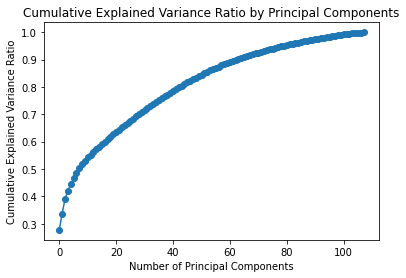

In [22]:
explained_variance_ratio = pca.explained_variance_ratio_
import numpy as np
import matplotlib.pyplot as plt

# Plot explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Principal Components')
plt.show()

In [23]:
index_90 = list(cumulative_variance_ratio>0.8).index(True)
index_90

43

In [24]:
percent_90 = reduced_features[:index_90,]

In [25]:
# Step 4: Cluster the features with k-means
kmeans = KMeans(n_clusters=5)  # Adjust the number of clusters as needed
feature_clusters = kmeans.fit_predict(percent_90.T)  # Transpose back for clustering

/home/users/arpitas/.local/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [26]:
# Step 5: Create a DataFrame with cluster labels
# features = peak_motif_counts_filtered.index[feature_variances >= high_variability_threshold]
sample_labels = peak_motif_counts_filtered.columns

In [27]:
# Create DataFrame for plotting
clustered_features_df = pd.DataFrame({
    'PC1': percent_90[0],
    'PC2': percent_90[1],
    'Cluster': feature_clusters,
    'Sample': sample_labels
})


In [28]:
cell_labels = list(k562_table.columns)+list(imr90_table.columns)+list(hepg2_table.columns)+list(h1esc_table.columns)+list(gm12878_table.columns)
cell_type = ["K562"]*len(list(k562_table.columns))
cell_type += ["IMR90"]*len(list(imr90_table.columns))
cell_type += ["HEPG2"]*len(list(hepg2_table.columns))
cell_type += ["H1ESC"]*len(list(h1esc_table.columns))
cell_type += ["GM12878"]*len(list(gm12878_table.columns))
cell_labels_df = pd.DataFrame(np.array([cell_type, cell_labels]).T, columns=["Cell Name", "Peak Num"])
cell_labels_df["Index"] = cell_labels_df["Peak Num"].str.split("peak").str[1].astype("int32")
cell_labels_df = cell_labels_df.sort_values(by="Index")
cell_labels_df

,Cell Name,Peak Num,Index
0,K562,peak0,0
1,K562,peak1,1
20146,K562,peak2,2
25249,K562,peak3,3
27355,K562,peak4,4
...,...,...,...
106634,HEPG2,peak216741,216741
106635,HEPG2,peak216742,216742
106636,HEPG2,peak216743,216743
106637,HEPG2,peak216744,216744


In [29]:
percent_90_df = pd.DataFrame(percent_90.T)
percent_90_df["Sample"]= sample_labels
percent_90_df = pd.merge(percent_90_df, cell_labels_df, left_on=["Sample"], right_on=["Peak Num"])
percent_90_df

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,Sample,Cell Name,Peak Num,Index
0,-0.430152,6.891945,-3.213451,3.293383,-0.752306,-2.413565,1.948883,-2.205726,0.172666,-1.612464,...,-1.444261,-0.585873,-1.211156,-1.426405,-0.348376,0.483409,peak0,K562,peak0,0
1,-1.850056,-1.631939,-0.140788,0.082438,-0.345825,0.234185,-0.923382,-0.281973,-0.245634,-0.858840,...,-0.671746,0.819415,0.554124,0.309720,-0.187908,1.184376,peak1,K562,peak1,1
2,-2.456148,-0.897330,0.251690,0.391395,-0.819400,-0.700824,0.202407,-0.645770,0.862209,-0.746713,...,0.766134,2.075092,0.287888,-0.618445,-0.289364,0.247309,peak10,K562,peak10,10
3,-2.312471,-1.256838,0.718363,-0.785566,-0.294845,0.116360,0.746588,-0.110521,-0.425738,-0.579835,...,0.683014,-0.823537,-0.084878,1.230533,0.051871,-0.152359,peak1000,K562,peak1000,1000
4,-1.501299,-1.690148,-0.498384,0.128762,-0.275010,0.293873,0.045203,-0.244448,0.311324,0.181313,...,0.347647,-0.794871,-0.308897,-0.443797,-1.122468,0.356526,peak10002,K562,peak10002,10002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216740,-2.606893,-0.567002,0.088945,0.200248,-0.404856,-0.074269,-0.384142,0.951432,0.300157,0.355897,...,-0.519617,-1.289401,0.023242,-0.197610,0.087244,-0.637366,peak99962,GM12878,peak99962,99962
216741,6.418225,0.043258,6.418744,2.822864,-0.525808,0.226973,-4.695740,-0.624075,-1.862649,-2.642598,...,0.835376,0.167647,0.367961,1.204915,0.958198,1.000255,peak99965,GM12878,peak99965,99965
216742,4.516048,3.872585,6.178124,0.710489,-0.932570,-1.264115,-2.186227,-0.435783,0.042893,3.938219,...,-0.762968,-0.227092,-1.343497,-0.390127,1.713715,-0.920177,peak99966,GM12878,peak99966,99966
216743,-2.191716,0.822826,0.346434,-2.113718,-0.100419,0.328769,-0.224278,-0.314903,-0.021905,0.278555,...,0.642763,-0.861729,-1.340806,0.666351,0.472203,-0.864451,peak99967,GM12878,peak99967,99967


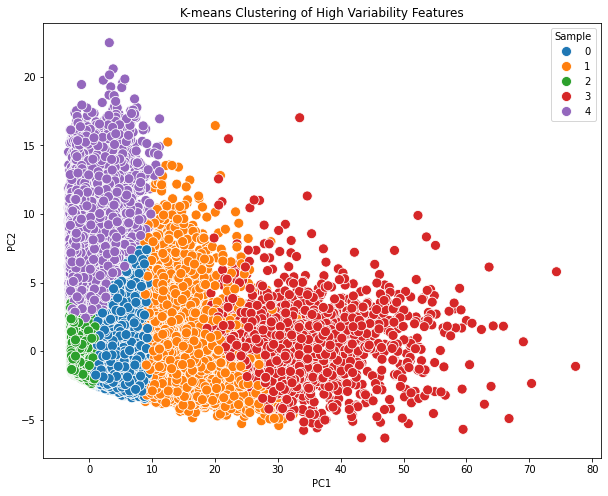

        PC1       PC2  Cluster     Sample
0 -0.430152  6.891945        4      peak0
1 -1.850056 -1.631939        2      peak1
2 -2.456148 -0.897330        2     peak10
3 -2.312471 -1.256838        2   peak1000
4 -1.501299 -1.690148        2  peak10002


In [30]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=clustered_features_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=100)

# Annotate with sample labels
# for i, row in clustered_features_df.iterrows():
#     plt.text(row['PC1'], row['PC2'], row['Sample'], fontsize=9)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering of High Variability Features')
plt.legend(title='Sample')
plt.show()

# Display the first few rows of the DataFrame with cluster labels
print(clustered_features_df.head())

In [31]:
labeled_cluster = pd.merge(clustered_features_df, cell_labels_df, left_on=["Sample"], right_on=["Peak Num"])[["PC1", "PC2", "Cluster", "Cell Name", "Sample"]]

In [32]:
labeled_cluster

,PC1,PC2,Cluster,Cell Name,Sample
0,-0.430152,6.891945,4,K562,peak0
1,-1.850056,-1.631939,2,K562,peak1
2,-2.456148,-0.897330,2,K562,peak10
3,-2.312471,-1.256838,2,K562,peak1000
4,-1.501299,-1.690148,2,K562,peak10002
...,...,...,...,...,...
216740,-2.606893,-0.567002,2,GM12878,peak99962
216741,6.418225,0.043258,0,GM12878,peak99965
216742,4.516048,3.872585,0,GM12878,peak99966
216743,-2.191716,0.822826,2,GM12878,peak99967


In [33]:
labeled_cluster

,PC1,PC2,Cluster,Cell Name,Sample
0,-0.430152,6.891945,4,K562,peak0
1,-1.850056,-1.631939,2,K562,peak1
2,-2.456148,-0.897330,2,K562,peak10
3,-2.312471,-1.256838,2,K562,peak1000
4,-1.501299,-1.690148,2,K562,peak10002
...,...,...,...,...,...
216740,-2.606893,-0.567002,2,GM12878,peak99962
216741,6.418225,0.043258,0,GM12878,peak99965
216742,4.516048,3.872585,0,GM12878,peak99966
216743,-2.191716,0.822826,2,GM12878,peak99967


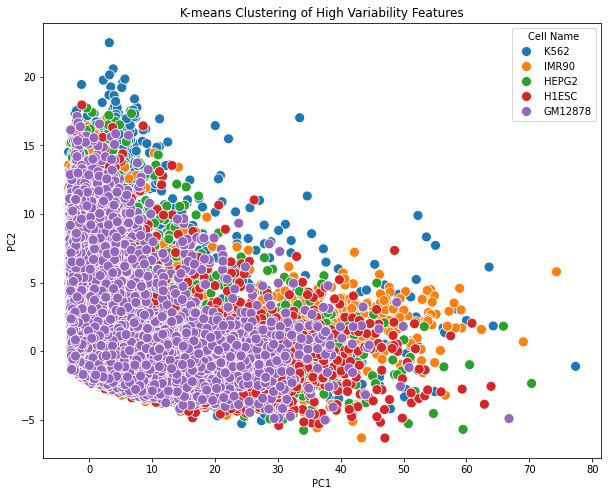

        PC1       PC2  Cluster     Sample
0 -0.430152  6.891945        4      peak0
1 -1.850056 -1.631939        2      peak1
2 -2.456148 -0.897330        2     peak10
3 -2.312471 -1.256838        2   peak1000
4 -1.501299 -1.690148        2  peak10002


In [34]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=labeled_cluster, x='PC1', y='PC2', hue='Cell Name', palette='tab10', s=100)

# Annotate with sample labels
# for i, row in clustered_features_df.iterrows():
#     plt.text(row['PC1'], row['PC2'], row['Sample'], fontsize=9)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K-means Clustering of High Variability Features')
plt.legend(title='Cell Name')
plt.show()

# Display the first few rows of the DataFrame with cluster labels
print(clustered_features_df.head())

In [35]:
clustered_features_df

,PC1,PC2,Cluster,Sample
0,-0.430152,6.891945,4,peak0
1,-1.850056,-1.631939,2,peak1
2,-2.456148,-0.897330,2,peak10
3,-2.312471,-1.256838,2,peak1000
4,-1.501299,-1.690148,2,peak10002
...,...,...,...,...
216740,-2.606893,-0.567002,2,peak99962
216741,6.418225,0.043258,0,peak99965
216742,4.516048,3.872585,0,peak99966
216743,-2.191716,0.822826,2,peak99967


In [36]:
reduced_features

array([[-4.30151963e-01, -1.85005605e+00, -2.45614771e+00, ...,
         4.51604789e+00, -2.19171565e+00, -2.18858985e+00],
       [ 6.89194513e+00, -1.63193902e+00, -8.97329839e-01, ...,
         3.87258478e+00,  8.22825957e-01, -3.60456791e-01],
       [-3.21345123e+00, -1.40787527e-01,  2.51689996e-01, ...,
         6.17812391e+00,  3.46434193e-01, -1.04195254e+00],
       ...,
       [ 6.78048811e-02, -8.69355706e-03, -2.91794968e-02, ...,
         3.61764772e-01, -4.64745521e-02,  6.14593302e-02],
       [-4.15564159e-01, -1.15073841e-01,  4.08499583e-03, ...,
         3.28215175e-01,  3.66313655e-02, -3.70680352e-01],
       [ 6.17456326e-02, -2.33717748e-02,  2.81517025e-02, ...,
         2.27583496e-01,  4.42107012e-01, -8.96297814e-01]])

In [37]:
cell_labels = list(k562_table.columns)+list(imr90_table.columns)+list(hepg2_table.columns)+list(h1esc_table.columns)+list(gm12878_table.columns)
cell_type = ["K562"]*len(list(k562_table.columns))
cell_type += ["IMR90"]*len(list(imr90_table.columns))
cell_type += ["HEPG2"]*len(list(hepg2_table.columns))
cell_type += ["H1ESC"]*len(list(h1esc_table.columns))
cell_type += ["GM12878"]*len(list(gm12878_table.columns))
cell_labels_df = pd.DataFrame(np.array([cell_type, cell_labels]).T, columns=["Cell Name", "Peak Num"])
cell_labels_df["Index"] = cell_labels_df["Peak Num"].str.split("peak").str[1].astype("int32")
cell_labels_df = cell_labels_df.sort_values(by="Index")
cell_labels_df

,Cell Name,Peak Num,Index
0,K562,peak0,0
1,K562,peak1,1
20146,K562,peak2,2
25249,K562,peak3,3
27355,K562,peak4,4
...,...,...,...
106634,HEPG2,peak216741,216741
106635,HEPG2,peak216742,216742
106636,HEPG2,peak216743,216743
106637,HEPG2,peak216744,216744


In [38]:
k562_table.shape[1]

37623

In [39]:
labels = ["K562"]*k562_table.shape[1]+["IMR90"]*imr90_table.shape[1]
labels += ["HEPG2"]*hepg2_table.shape[1]+["H1ESC"]*h1esc_table.shape[1]
labels += ["GM12878"]*gm12878_table.shape[1]

In [40]:
from sklearn.metrics import silhouette_score
silhouette_score(X=reduced_features.T, labels=labels)

-0.04603042701947369

In [41]:
from sklearn.metrics import rand_score
rand_score(list(cell_labels_df["Cell Name"]), clustered_features_df["Cluster"])

0.4823373769188225


PCA DataFrame:
       PC_1      PC_2      PC_3      PC_4      PC_5      PC_6      PC_7  \
0 -0.430152  6.891945 -3.213451  3.293383 -0.752306 -2.413565  1.948883   
1 -1.850056 -1.631939 -0.140788  0.082438 -0.345825  0.234185 -0.923382   
2 -2.456148 -0.897330  0.251690  0.391395 -0.819400 -0.700824  0.202407   
3 -2.312471 -1.256838  0.718363 -0.785566 -0.294845  0.116360  0.746588   
4 -1.501299 -1.690148 -0.498384  0.128762 -0.275010  0.293873  0.045203   

       PC_8      PC_9     PC_10  ...     PC_34     PC_35     PC_36     PC_37  \
0 -2.205726  0.172666 -1.612464  ... -2.580246  3.262430 -0.674954 -0.281945   
1 -0.281973 -0.245634 -0.858840  ...  0.267597  0.048205 -0.440214  0.795407   
2 -0.645770  0.862209 -0.746713  ...  1.862221  0.210793  0.508001 -0.072864   
3 -0.110521 -0.425738 -0.579835  ...  0.220042 -0.437755 -1.282950  0.470921   
4 -0.244448  0.311324  0.181313  ... -0.397066 -0.286278 -0.736530 -0.444936   

      PC_38     PC_39     PC_40     PC_41     PC_42 

/home/users/arpitas/.local/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



UMAP DataFrame:
     UMAP_1    UMAP_2 Cell Type
0 -2.545555 -2.784665      K562
1  3.334499 -4.026144      K562
2  1.950142  1.605607      K562
3  2.056389 -1.718658      K562
4  1.347533 -5.347775      K562


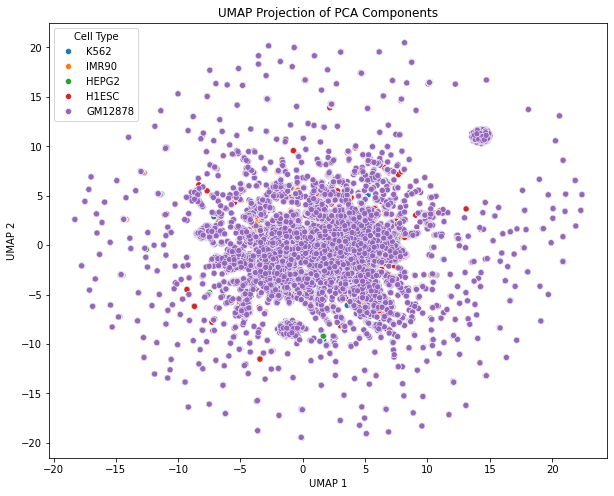

In [42]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PCA result to a DataFrame
pca_df = pd.DataFrame(np.array(percent_90_df[np.arange(index_90)]), columns=[f'PC_{i+1}' for i in range(index_90)])

# Display the PCA DataFrame
print("\nPCA DataFrame:")
print(pca_df.head())

# Apply UMAP to the principal components
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(pca_df)

# Convert UMAP result to a DataFrame
umap_df = pd.DataFrame(umap_result, columns=['UMAP_1', 'UMAP_2'])
umap_df["Cell Type"] = percent_90_df["Cell Name"]

# Display the UMAP DataFrame
print("\nUMAP DataFrame:")
print(umap_df.head())

# Plot the UMAP projection
plt.figure(figsize=(10, 8))
sns.scatterplot(x='UMAP_1', y='UMAP_2', data=umap_df, hue="Cell Type")
plt.title('UMAP Projection of PCA Components')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()
